# LCPB 20-21 Exercise 1
## RandomGroup
### Alessandro Casalino 2015122
### Michele M. Crudele 2021858
### Sabrina Giorgetti 2013375
### Daniele Mellino 2013373

## Introduction

The goal of this exercise is to show a quantitative statistical comparison of the performances of various gradient descent methods for the function: <br><br>
$$
rippled\_function_q(x, y) = 1 + \frac{1}{2} q \ (x^2 + y^2) - \cos{[2 \pi (x y - y^2)]}
$$
<br>We'll also show an example where ADAM algorithm starts to become unstable with respect to a minimum that was reached at some earlier iteration $t$.

## Overview

We define a grid $Q$ of initial points equally spaced in the square $S = [-3, 3] \times [-3, 3]$. Each linear dimension of $S$ is subdivided into 20 points: this gives us a total of 400 starting points. We use 5 different algorithms to search the minimum of the function:
<ol>
<li> Vanilla gradient descent </li>
<li> Gradient descent with momentum </li>
<li> Nesterov (NAG) </li>
<li> RMSprop </li>
<li> ADAM </li>
</ol>
We set the parameter $q$ of $rippled\_function$ equal to $6$ and we calculate the gradient of the function, needed for the algorithms:<br><br>
$$
\vec{\nabla}rippled\_function_q(x, y) = \begin{pmatrix}{ q x + 2 \pi y \sin{[2 \pi (x y - y^2)]} } \\{ q y + 2 \pi (x - 2y) \sin{[2 \pi(x y - y^2)]} } \end{pmatrix}
$$
<br>For each method, we perform a minimization starting from each of the points in Q and compute the average value of the function as a function of time during these minimizations.
The best possible value for the learning rate is chosen a posteriori for each algorithm by means of a simple function we implement, while we leave the other parameters (gamma, beta, epsilon) equal to their default value. We also add a small amount of noise in order to help the algorithms to jump out of local minima, that are quite a lot in the function we are dealing with.<br><br>
Finally, for showing an example of ADAM algorithm instability we use the function:<br><br>
$$
z=x^2+y^2+\cos(x)
$$

## Imported libraries

In [1]:
import numpy as np
from numba import njit
#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

## Useful functions for plotting

In [2]:
def plot_surface(x, y, z, azim=-60, elev=50, dist=8, cmap="RdYlBu_r"):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': 0, 'vmax': 40}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(0, 45)
    
    plt.xticks([-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3], ["-3", "-2.5", "-2", "-1.5", "-1", "-0.5", "0", "0.5", "1", "1.5", "2", "2.5", "3"])
    plt.yticks([-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3], ["-3", "-2.5", "-2", "-1.5", "-1", "-0.5", "0", "0.5", "1", "1.5", "2", "2.5", "3"])
    t_zlist = list(range(0, 45, 5))
    ax.set_zticks(t_zlist)
    ax.set_zticklabels([str(n) for n in t_zlist])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;
    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

## Function used to test the minimization algorithms

In [3]:
@njit
def rippled_function(x,y, q=6):
    return 1 + 0.5*q*(x*x+y*y) - np.cos(2*np.pi*(x*y-y*y))

@njit
def grad_rippled_function(params, q=6):
    x=params[0]
    y=params[1]
    grad_x= q*x+2*np.pi*y*np.sin(2*np.pi*(x*y-y*y))
    grad_y= q*y+2*np.pi*(x-2*y)*np.sin(2*np.pi*(x*y-y*y))
    return [grad_x,grad_y]

## Example plotting

<ipython-input-4-56c03d4f7fc4>:6: UserWarning: Log scale: values of z <= 0 have been masked
  cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 43), norm=LogNorm(), cmap="RdYlBu_r")


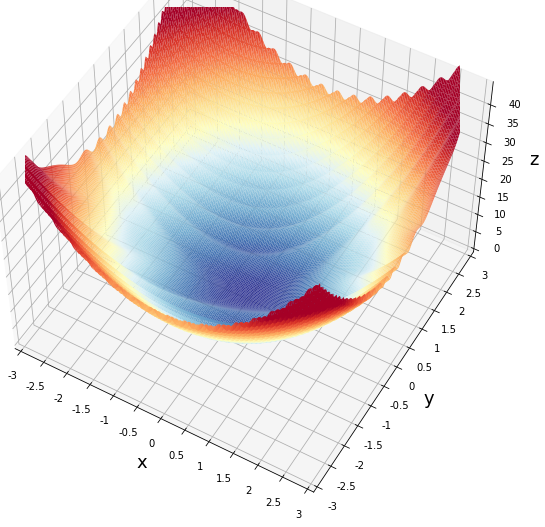

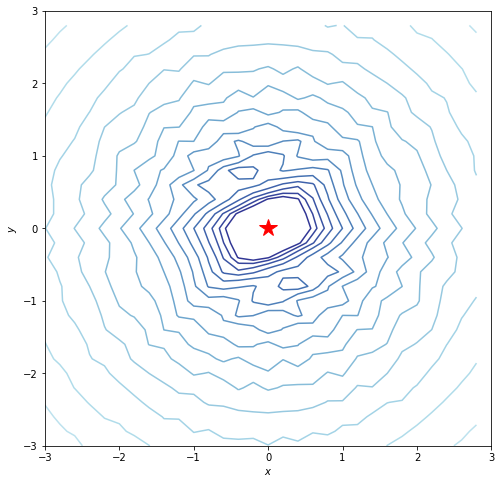

In [4]:
def contour_rippled_function():
    #plot rippled function
    x, y = np.meshgrid(np.arange(-3, 3, 0.2), np.arange(-3, 3, 0.2))
    fig, ax = plt.subplots(figsize=(8, 8))
    z=rippled_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 43), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(0,0, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    
    return fig,ax


#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-3:3:200j, -3:3:200j]
fig, ax = plot_surface(x,y,rippled_function(x,y))

#Contour plot of Rippled Function
fig, ax = contour_rippled_function()
plt.show()

## Algorithms used for minimization

### Mean-gradient based methods

#### Gradient Descent

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given a function $f$ and two parameters $(x, y)$, we adjust the parameters at each iteration so that

$$(x, y)_{t+1}= (x, y)_t - \eta_t \nabla_{(x, y)} f(x, y),$$

where we have introduced the learning rate $\eta_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\eta_t$. If $\eta_t$ is too large, then one can wildly oscillate around minima and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\eta_t$ is too small, then the learning/minimization procedure becomes extremely slow.

#### Gradient Descent with Momentum
One problem with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima. 

Momentum becomes especially important when we start thinking about stochastic gradient descent with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, we can add a memory or momentum term to the stochastic gradient descent term above:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_{(x, y)} f\left((x, y)_t\right),\\
(x, y)_{t+1}= (x, y)_t -v_{t},
$$

with $0 \le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with classical momentum or CM for short.

#### Nesterov accelerated gradient (NAG)
A final widely used variant of gradient descent with momentum is called the Nesterov accelerated gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to at time $t+1$, namely, $(x, y)_t -\gamma v_{t-1}$. Thus, the update becomes
$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_{(x, y)} f((x, y)_t-\gamma v_{t-1})\\
(x, y)_{t+1}= (x, y)_t - v_{t}
$$

### Gradient Descents that utilize the second moment

#### RMS prop (Root-Mean-Square propagation)
In RMS prop (Root-Mean-Square propagation), in addition to keeping a running average of the first moment of the gradient, we also keep track of the second moment through a moving average. The update rule for RMS prop is given by
$$
\mathbf{g}_t = \nabla_{(x,y)} f(x,y) \\
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
(x,y)_{t+1}=(x,y)_t + \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber \\
$$
where $\beta$ controls the averaging time of the second moment and is typically taken to be about $\beta=0.9$, $\eta_t$ is a learning rate typically chosen to be $10^{-3}$, and $\epsilon\sim 10^{-8}$ is a small regularization constant to prevent divergences. It is clear from this formula that the learning rate is reduced in directions where the norm of the gradient is consistently large. This greatly speeds up the convergence by allowing us to use a larger learning rate for flat directions.

#### ADAM optimizer
In ADAM, we keep a running average of both the first and second moment of the gradient and use this information to adaptively change the learning rate for different parameters. In addition to keeping a running average of the first and second moments of the gradient, ADAM performs an additional bias correction to account for the fact that we are estimating the first two moments of the gradient using a running average (denoted by the hats in the update rule below). The update rule for ADAM is given by (where multiplication and division are understood to be element wise operations)
$$
\mathbf{g}_t = \nabla_{x,y} f(x,y) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1} \nonumber \\
\hat{\mathbf{s}}_t ={\mathbf{s}_t \over1-\beta_2} \nonumber \\
(x,y)_{t+1}= (x,y)_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber 
$$
where $\beta_1$ and $\beta_2$ set the memory lifetime of the first and second moment and are typically take to be $0.9$ and $0.99$ respectively, and $\eta$ and $\epsilon$ are identical
to RMSprop.

In [5]:
# Vanilla gradient descend
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# Gradient descent with momentum
def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=np.zeros(len(init))
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# Nesterov (NAG)
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=np.zeros(len(init))
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# RMS propagator
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init#Import relevant packages
    grad_sq=np.zeros(len(init));
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj

# ADAM
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=np.zeros(len(init));
    grad_sq=np.zeros(len(init));
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

### Compiled version of minimization algorithms

In [6]:
# Vanilla gradient descend
@njit
def gd_jit(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    #This is a simple optimizer
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# Gradient descent with momentum
@njit
def gdm_jit(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=np.zeros(len(init))
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# Nesterov (NAG)
@njit
def NAG_jit(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=np.zeros(len(init))
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# RMS propagator
@njit
def rms_jit(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init#Import relevant packages
    grad_sq=np.zeros(len(init));
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj

# ADAM
@njit
def adams_jit(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=init
    param_traj=np.zeros((n_epochs+1,2))
    param_traj[0,]=init
    v=np.zeros(len(init));
    grad_sq=np.zeros(len(init));
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

## Investigating effect of learning rate

In this section we want to investigate the dependence on the learning rate $\eta$ of the different methods, GD, GD with momentum, NAG, RMS and ADAM, for the considered function. 

The learning rate parameter is related to the convergence velocity of the gradient: in general a higher value of $\eta$ will lead to a faster convergence of the algorithm, while instead reducing $\eta$  the convergence will be slower. The problem is that a too small learnig rate would make the convergence too slow, while a too high one would make the algorithm miss minima, as the jumps are too big, so we have to choose it carefully.
As we can see in the plot below, starting from different initial points, for different values of the learning rate, the trajectory will diverge or converge based on the value of $\eta$. From these plots we can also intuitively find, at least in terms of order of magnitude, the optimal learning parameter $\eta$ for each of the different methods.

### Vanilla gradient descent

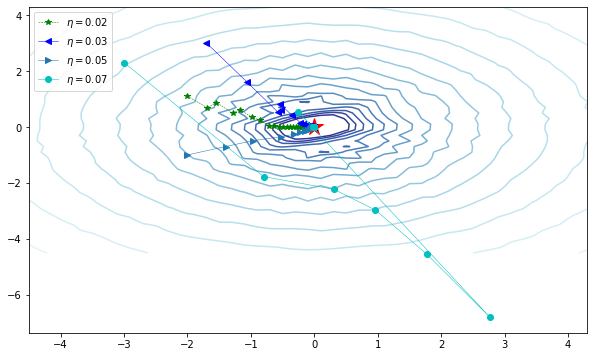

In [7]:
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(rippled_function(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,1.1]
init2=[-1.7,3]
init3=[-2,-1]
init4=[-3,2.3]
init1 = np.array(init1)
init2 = np.array(init2)
init3 = np.array(init3)
init4 = np.array(init4)
eta1=0.02
eta2=0.03
eta3=0.05
eta4=0.07
gd_1=gd(grad_rippled_function,init1, n_epochs=1000, eta=eta1)
gd_2=gd(grad_rippled_function,init2, n_epochs=1000, eta=eta2)
gd_3=gd(grad_rippled_function,init3, n_epochs=1000, eta=eta3)
gd_4=gd(grad_rippled_function,init4, n_epochs=1000, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GDregimes.pdf", bbox_inches='tight')

### Gradient Descent with Momentum

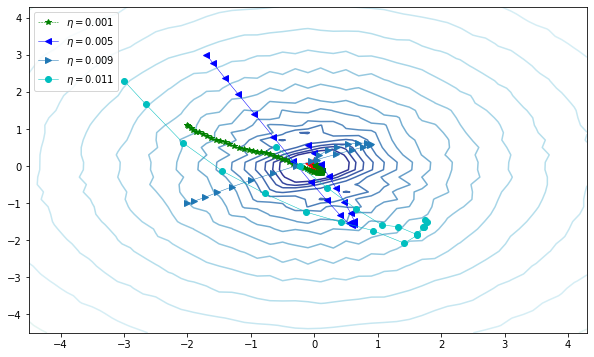

In [8]:
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(rippled_function(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,1.1]
init2=[-1.7,3]
init3=[-2,-1]
init4=[-3,2.3]
init1 = np.array(init1)
init2 = np.array(init2)
init3 = np.array(init3)
init4 = np.array(init4)
eta1=0.001
eta2=0.005
eta3=0.009
eta4=0.011
gd_1=gd_with_mom(grad_rippled_function,init1, n_epochs=80, eta=eta1)
gd_2=gd_with_mom(grad_rippled_function,init2, n_epochs=20, eta=eta2)
gd_3=gd_with_mom(grad_rippled_function,init3, n_epochs=20, eta=eta3)
gd_4=gd_with_mom(grad_rippled_function,init4, n_epochs=20, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GDMregimes.pdf", bbox_inches='tight')

### NAG

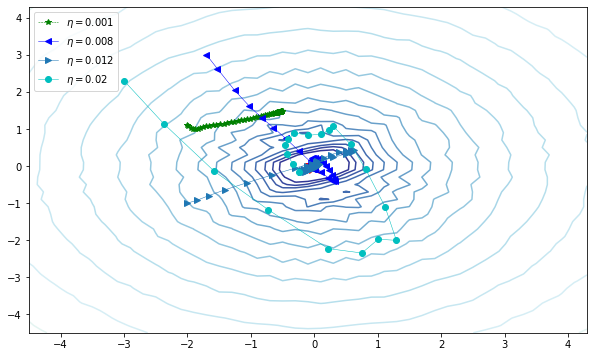

In [9]:
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(rippled_function(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,1.1]
init2=[-1.7,3]
init3=[-2,-1]
init4=[-3,2.3]
init1 = np.array(init1)
init2 = np.array(init2)
init3 = np.array(init3)
init4 = np.array(init4)
eta1=0.001
eta2=0.008
eta3=0.012
eta4=0.02
nag_1=NAG(grad_rippled_function,init1, n_epochs=100, eta=eta1)
nag_2=NAG(grad_rippled_function,init2, n_epochs=100, eta=eta2)
nag_3=NAG(grad_rippled_function,init3, n_epochs=100, eta=eta3)
nag_4=NAG(grad_rippled_function,init4, n_epochs=20, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,nag_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,nag_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,nag_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,nag_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("NAG.pdf", bbox_inches='tight')

### RMS

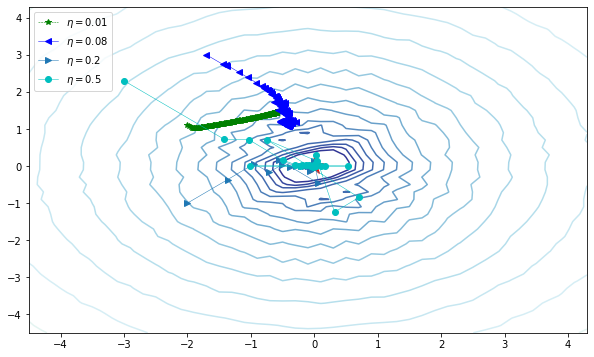

In [10]:
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(rippled_function(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,1.1]
init2=[-1.7,3]
init3=[-2,-1]
init4=[-3,2.3]
init1 = np.array(init1)
init2 = np.array(init2)
init3 = np.array(init3)
init4 = np.array(init4)
eta1=0.01
eta2=0.08
eta3=0.2
eta4=0.5
rms_1=rms_prop(grad_rippled_function,init1, n_epochs=1000, eta=eta1)
rms_2=rms_prop(grad_rippled_function,init2, n_epochs=100, eta=eta2)
rms_3=rms_prop(grad_rippled_function,init3, n_epochs=100, eta=eta3)
rms_4=rms_prop(grad_rippled_function,init4, n_epochs=100, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,rms_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,rms_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,rms_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,rms_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("RMS.pdf", bbox_inches='tight')

### ADAM

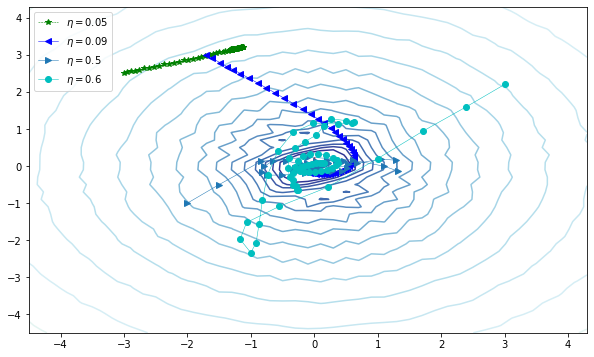

In [11]:
a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(rippled_function(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-3,2.5]
init2=[-1.7,3]
init3=[-2,-1]
init4=[3,2.2]
init1 = np.array(init1)
init2 = np.array(init2)
init3 = np.array(init3)
init4 = np.array(init4)
eta1=0.05
eta2=0.09
eta3=0.5
eta4=0.6
adams_1=adams(grad_rippled_function,init1, n_epochs=1000, eta=eta1)
adams_2=adams(grad_rippled_function,init2, n_epochs=1000, eta=eta2)
adams_3=adams(grad_rippled_function,init3, n_epochs=60, eta=eta3)
adams_4=adams(grad_rippled_function,init4, n_epochs=60, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,adams_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,adams_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,adams_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,adams_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("adams.pdf", bbox_inches='tight')

In the following part we use the different methods GD, GD with momentum, NAG, RMS and ADAM to find the converging trajectories starting from four different initial conditions, with a fixed number of steps and a different $\eta$, based on the method. 
The thing you should notice is that the algorithms can converge or not, with respect to the starting point.

<ipython-input-4-56c03d4f7fc4>:6: UserWarning: Log scale: values of z <= 0 have been masked
  cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 43), norm=LogNorm(), cmap="RdYlBu_r")


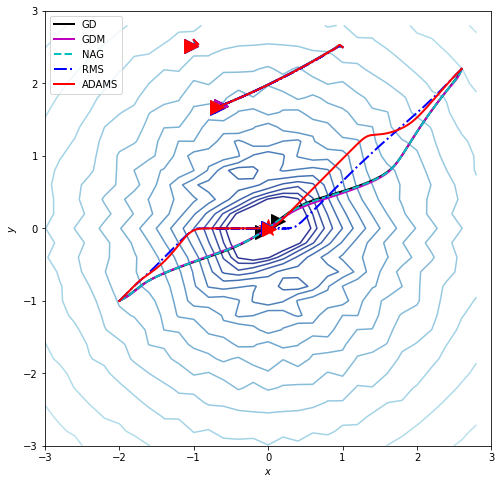

In [12]:
plt.close()
#Make static plot of the results

Nsteps=10**4

etagd = 0.00005
etagdm = 0.00005
etanag = 0.00002
etarms = 0.002
etadams = 0.002

fig1, ax1=contour_rippled_function()

init1=np.array([1,2.5])

gd_trajectory1=gd(grad_rippled_function,init1,Nsteps, eta=etagd, noise_strength=0)
gdm_trajectory1=gd_with_mom(grad_rippled_function,init1,Nsteps,eta=etagdm, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(grad_rippled_function,init1,Nsteps,eta=etanag, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(grad_rippled_function,init1,Nsteps,eta=etarms, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(grad_rippled_function,init1,Nsteps,eta=etadams, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

init2=np.array([-1,2.6])

gd_trajectory2=gd(grad_rippled_function,init2,Nsteps, eta=etagd, noise_strength=0)
gdm_trajectory2=gd_with_mom(grad_rippled_function,init2,Nsteps,eta=etagdm, gamma=0.9,noise_strength=0)
NAG_trajectory2=NAG(grad_rippled_function,init2,Nsteps,eta=etanag, gamma=0.9,noise_strength=0)
rms_prop_trajectory2=rms_prop(grad_rippled_function,init2,Nsteps,eta=etarms, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory2=adams(grad_rippled_function,init2,Nsteps,eta=etadams, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gdm_trajectory2, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory2, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory2,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory2,'ADAMS', 'r')

init3=np.array([-2,-1])

gd_trajectory3=gd(grad_rippled_function,init3,Nsteps, eta=etagd, noise_strength=0)
gdm_trajectory3=gd_with_mom(grad_rippled_function,init3,Nsteps,eta=etagdm, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(grad_rippled_function,init3,Nsteps,eta=etanag, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(grad_rippled_function,init3,Nsteps,eta=etarms, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(grad_rippled_function,init3,Nsteps,eta=etadams, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

init4=np.array([2.6,2.2])

gd_trajectory4=gd(grad_rippled_function,init4,Nsteps, eta=etagd, noise_strength=0.1)
gdm_trajectory4=gd_with_mom(grad_rippled_function,init4,Nsteps,eta=etagdm, gamma=0.9,noise_strength=0.1)
NAG_trajectory4=NAG(grad_rippled_function,init4,Nsteps,eta=etanag, gamma=0.9,noise_strength=0.1)
rms_prop_trajectory4=rms_prop(grad_rippled_function,init4,Nsteps,eta=etarms, beta=0.9,epsilon=10**-8,noise_strength=0.1)
adam_trajectory4=adams(grad_rippled_function,init4,Nsteps,eta=etadams, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0.1)

overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')

plt.show()

# Quantitative statistical comparison of the performance of different algorithms:

In this section we quantitatively and statistically compare the performances of the five different minimizing methods with respect to the rippled function we are dealing with. 
The idea is the following: we consider a grid of 20 x 20 = 400 equally spaced points in the square [-3,3]x[-3,3] and then we perform a minimization starting from each one of them. We therefore obtain different trajectories, that represent the "path" that method is following in its way to the minimum of the function, starting from some point in the starting grid. For each of the points in those trajectories, we compute the value the function assumes in that points and then perform an average over all the trajectories. We perform these steps for each of the methods we are using, obtaining the curves plotted below. As far as the value of the parameters, we only look for the best possible learning rate ("eta"), leaving all the other parameters equal to their most common values. You can find the way we discover the best possible learning rate later on in this jupyter.
You can see that the results are unexpected, as the simplest method (Vanilla GD) is the one for which we obtain the best results; indeed, the average value of the function goes to zero in the fastest way if compared to the other methods.

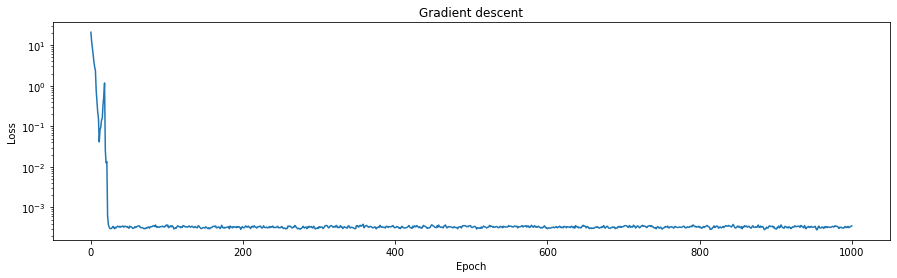

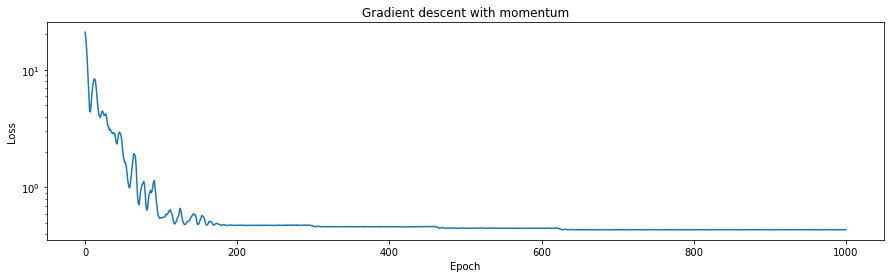

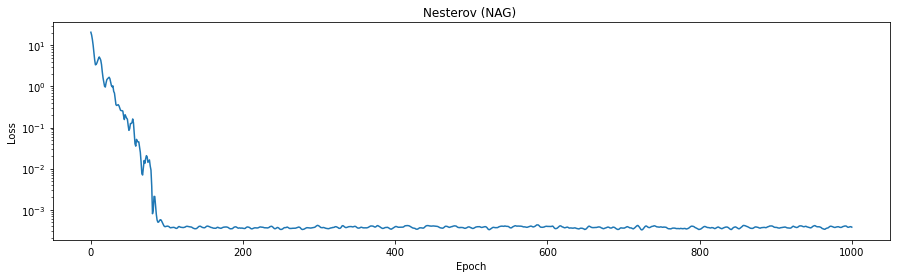

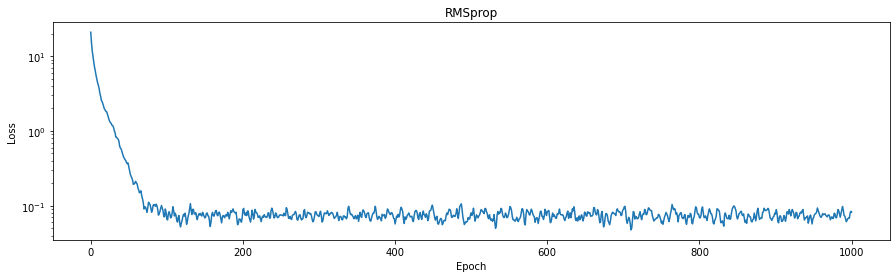

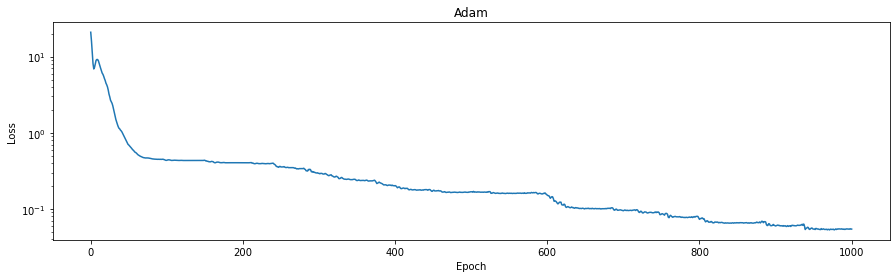

In [46]:
l = np.linspace(-3,3,20)
init = [[x1,x2] for x1 in l for x2 in l]
init = np.array(init)

Nsteps = 1000

gd_sum = np.zeros(1001)
gdm_sum = np.zeros(1001)
NAG_sum = np.zeros(1001)
rms_sum = np.zeros(1001)
adam_sum = np.zeros(1001)


@njit
def create_sums(gd_sum, gdm_sum, NAG_sum, rms_sum, adam_sum):
    for index in range(init.shape[0]):
        i = init[index]
        gd_t=gd_jit(grad_rippled_function,i,Nsteps, eta=0.055, noise_strength=0.1)
        gdm_t=gdm_jit(grad_rippled_function,i,Nsteps, eta=0.009, gamma=0.9,noise_strength=0.1)
        NAG_t=NAG_jit(grad_rippled_function,i,Nsteps, eta=0.012, gamma=0.9,noise_strength=0.1)
        rms_prop_t=rms_jit(grad_rippled_function,i,Nsteps, eta=0.2, beta=0.9,epsilon=10**-8,noise_strength=0.1)
        adam_t=adams_jit(grad_rippled_function,i,Nsteps, eta=0.5, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0.1)

        #print(gd_t)
        gd_sum += rippled_function(gd_t[:,0], gd_t[:,1])
        gdm_sum += rippled_function(gdm_t[:,0], gdm_t[:,1])
        NAG_sum += rippled_function(NAG_t[:,0], NAG_t[:,1])
        rms_sum += rippled_function(rms_prop_t[:,0], rms_prop_t[:,1])
        adam_sum += rippled_function(adam_t[:,0], adam_t[:,1])
        
    return (gd_sum, gdm_sum, NAG_sum, rms_sum, adam_sum)

gd_sum, gdm_sum, NAG_sum, rms_sum, adam_sum = create_sums(gd_sum, gdm_sum, NAG_sum, rms_sum, adam_sum)
    
gd_mean = gd_sum / init.shape[0]
plt.figure(figsize=(15,4))
plt.xlabel("Epoch")
plt.title("Gradient descent")
plt.yscale("log")
plt.ylabel("Loss")
plt.plot(gd_mean)

gdm_mean = gdm_sum / init.shape[0]
plt.figure(figsize=(15,4))
plt.yscale("log")
plt.title("Gradient descent with momentum")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(gdm_mean)


NAG_mean = NAG_sum / init.shape[0]
plt.figure(figsize=(15,4))
plt.yscale("log")
plt.xlabel("Epoch")
plt.title("Nesterov (NAG) ")
plt.ylabel("Loss")
plt.plot(NAG_mean)

rms_mean = rms_sum / init.shape[0]
plt.figure(figsize=(15,4))
plt.yscale("log")
plt.xlabel("Epoch")
plt.title("RMSprop")
plt.ylabel("Loss")
plt.plot(rms_mean)

adam_mean = adam_sum / init.shape[0]
plt.figure(figsize=(15,4))
plt.yscale("log")
plt.plot(adam_mean)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Adam")
plt.show()
# print(gd_mean)

# m = x, y = np.mgrid[-3:3:20j, -3:3:20j]
# f = rippled_function(x,y)
# print(np.mean(f))

## Best possible learning rate
To find the best possible learning rate for each algorithm, we start by constructing a grid of points: these are used as starting points in minimization algorithms. Furthermore, an array of eta values is defined for testing. <br>
We construct two loops: one for eta values and another for initial ponts. The idea is to take the average value of the function along the trajectories traced by the algorithms and to consider as best learning rate the one for which we have the lowest integral value of that average vs time. This because we expect that for the best learning rate it will decrease faster to the minimum value of the rippled function, that is equal to zero and this implies a lower integral value (if we always consider the same range on the x-axis) <br>
As an example, we plot in the next cell the above-mentioned procedure for ADAM algorithm.

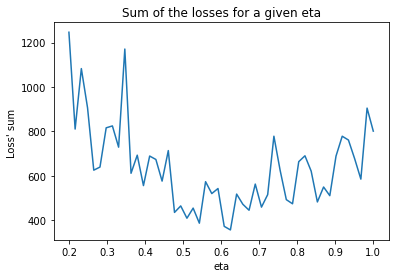

In [22]:
### Function to find the best eta ###
l = np.linspace(-3,3,10)
init = [[x1,x2] for x1 in l for x2 in l]
init = np.array(init)


eta_values = np.linspace(0.2, 1, 50)

sums = np.zeros(50)

for j in range(eta_values.shape[0]):
    gdm_sum = np.zeros(1001)
    for i in init:
        gdm_t = adams_jit(grad_rippled_function, i, 1000, eta=eta_values[j],gamma=0.9,beta=0.99, noise_strength=0.1)
        gdm_sum += rippled_function(gdm_t[:,0], gdm_t[:,1])

    gd_mean = gdm_sum / init.shape[0]
    sums[j] = gd_mean.sum()
# print(eta_values)
# print(sums)
plt.plot(eta_values, sums)
plt.xlabel("eta")
plt.ylabel("Loss' sum ")
plt.title("Sum of the losses for a given eta")
plt.show()

# Curiosity about Adam convergence

### Example of Adam's failure


Adam not always converge to the expected result, here we give an example of a function in which it does not work.
Consider the function : 


$$
f_t(x) =
  \begin{cases} Cx, & t mod(3) =1
             \\ -x, & otherwise
  \end{cases}
$$
with C>2 and x in $[-1,1]$.


For this function sequence,  it is easy to see that the point $x=−1$ provides the minimum regret.


Source: https://openreview.net/pdf?id=ryQu7f-RZ (Chapter 3)

In [15]:
# We don't actually need the function, we just need its (sub)gradient
def grad(t, C=15):
    if t % 3 == 1:
        return C
    else:
        return -1
# We look at values in [-1, 1]
def project(x):
    if -1 <= x <= 1:
        return x
    elif x <= -1:
        return -1
    else:
        return 1
    
num_iterations = 10000
C = 20
x = 0
lr = 0.0001
for t in range(num_iterations):
    g_t = grad(t, C)
    x = project(x - lr * g_t)
print("stochastic gradient descent leads to the correct result : ",x)

stochastic gradient descent leads to the correct result :  -0.9998


In [16]:
m_t = 0
v_t = 0
epsilon = 1e-7
x = 0
beta_1 = 0.0
beta_2 = 1 / (1 + C * C )
step_size = 0.1
v_hat = 0

for t in range(num_iterations):
    
    g_t = grad(t, C)
    m_t = beta_1 * m_t + (1 - beta_1) * g_t
    v_t = beta_2 * v_t + (1 - beta_2) * (g_t * g_t)
    m_hat = m_t / (1 - np.power(beta_1, t + 1))
    v_hat = v_t / (1 - np.power(beta_2, t + 1))
    
    x = project(x - step_size * m_hat / (v_hat + epsilon))
print(" Adam instead does not lead to a good solution : ",x)

 Adam instead does not lead to a good solution :  1


### Show an example where ADAM algorithm starts to become unstable with respect to a minimum that was reached at some earlier iteration t.


We show it for the surface $z=x^2+y^2+cos(x)$, as we can see in the graphs below, given an initial point after reaching the convergence the Adam method becomes unstable.

In [17]:

def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj


<ipython-input-18-2dcb78505912>:27: UserWarning: Log scale: values of z <= 0 have been masked
  ax[0,0].contour(x, y, z, levels=np.logspace(0.0, 2, 40), norm=LogNorm(), cmap="RdYlBu_r")
<ipython-input-18-2dcb78505912>:31: UserWarning: Log scale: values of z <= 0 have been masked
  ax[1,0].contour(x, y, z, levels=np.logspace(0.0, 2, 40), norm=LogNorm(), cmap="RdYlBu_r")


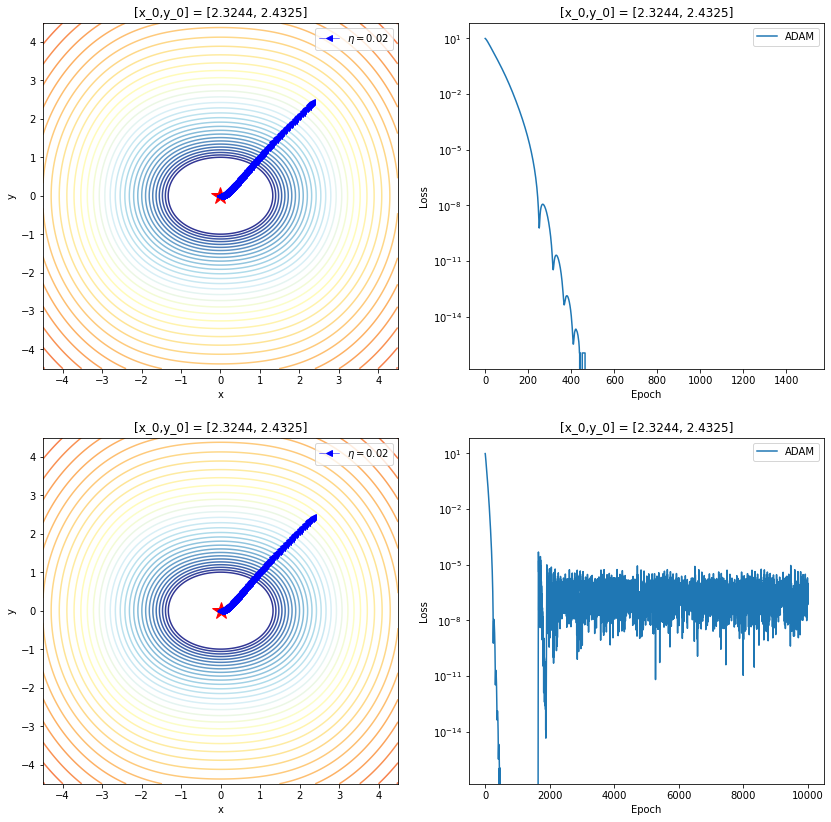

In [18]:
def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1+np.cos(x)

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x-np.sin(x)
    grad_y= 2*b*y

    return [grad_x,grad_y]


#x, y = np.mgrid[-1:1:31j, -1:1:31j]
#fig1,ax1 =contour_minima_function()
#plt.show()


#plt.close()
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.01), np.arange(-4.50, 4.5, 0.01))
z=np.abs(minima_surface(x,y))
fig, ax = plt.subplots(2,2,figsize=(14, 14))

init1 = [2.3244,2.4325]
init2 = [2.3244, 2.4325]
init  = [init1, init2]

ax[0,0].contour(x, y, z, levels=np.logspace(0.0, 2, 40), norm=LogNorm(), cmap="RdYlBu_r")
ax[0,0].set_xlim((-4.5, 4.5))
ax[0,0].set_ylim((-4.5, 4.5))
ax[0,0].plot(0,0, 'r*', markersize=18)
ax[1,0].contour(x, y, z, levels=np.logspace(0.0, 2, 40), norm=LogNorm(), cmap="RdYlBu_r")
ax[1,0].plot(0,0, 'r*', markersize=18)

ADAM_traj_1 = adams(grad_minima_surface, init1, n_epochs=1500, eta=0.02, gamma=0.9, beta=0.99)
overlay_trajectory_contour(ax[0,0], ADAM_traj_1, r'$\eta =$%s'% 0.02, 'b-<', lw=0.5)
ax[0,1].plot(np.arange(len(ADAM_traj_1)), minima_surface(ADAM_traj_1[:,0], ADAM_traj_1[:,1]), label='ADAM')
ax[0,1].set_yscale("log")

ADAM_traj_2 = adams(grad_minima_surface, init2, n_epochs=10000, eta=0.02, gamma=0.9, beta=0.99)
overlay_trajectory_contour(ax[1,0], ADAM_traj_2, r'$\eta =$%s'% 0.02, 'b-<', lw=0.5)
ax[1,1].plot(np.arange(len(ADAM_traj_2)), minima_surface(ADAM_traj_2[:,0], ADAM_traj_2[:,1]), label='ADAM')
ax[1,1].set_yscale("log")

for i in range(2):
    ax[i,0].set_xlabel("x")
    ax[i,0].set_ylabel("y")
    ax[i,1].set_xlabel("Epoch")
    ax[i,1].set_ylabel("Loss")

for i in range(2):
    for j in range(2):
        ax[i,j].set_title(r"[x_0,y_0] = " + str(init[i]))
        ax[i,j].legend()

plt.show()